### 导入数据

选择了[Acea Smart Water Analytics challenge](https://www.kaggle.com/c/acea-water-prediction/)的部分数据进行导入。
对于数据增加了部分人为处理：

- 将时间顺序打乱
- 部分数值为0的数据实际上应该是NULL，这边做了相应的还原

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/Time\ Series\ Forecasting

/content/drive/MyDrive/Time Series Forecasting


In [3]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("Aquifer_Petrignano.csv")
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,01/01/2007,NaN,-26.68,-25.95,NaN,NaN,-29918.592,NaN
1,01/01/2008,NaN,-31.22,-30.45,NaN,NaN,-26686.368,NaN
2,01/01/2009,0.0,-31.96,-31.14,5.2,4.9,-24530.688,2.4
3,01/01/2010,26.5,-29.78,-29.08,8.3,7.9,-25730.784,3.1
4,01/01/2011,0.0,-25.56,-24.82,5.6,5.5,-28958.688,2.5


### 数据预处理

可以看到部分数据中有很多的NaN值，我们希望去除掉这些数据。除此之外，有两列关于地下水深度的数据，我们只保留其中一个。最后，我们对列名进行简化。

In [4]:
# 去除缺失值
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
# 只保留一列地下水数据
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

In [5]:
# 简化列名
df.columns = ['Date', 'Rainfall', 'Depth_to_Groundwater', 'Temperature', 'Drainage_Volume', 'River_Hydrometry']
targets = ['Depth_to_Groundwater']
features = [feature for feature in df.columns if feature not in targets]
df.head()

,Date,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,01/01/2010,26.5,-29.08,8.3,-25730.784,3.1
2,01/01/2011,0.0,-24.82,5.6,-28958.688,2.5
3,01/01/2012,0.0,-27.27,1.5,-35187.264,2.0
4,01/01/2013,0.0,-30.81,1.6,-28532.736,2.5


In [6]:
from datetime import datetime, date 

df['Date'] = pd.to_datetime(df.Date, format = '%d/%m/%Y')

在对时间序列的数据进行处理前，我们要保证数据是按时间顺序排列的，并且时间间隔要保持一致。

In [7]:
# 对时间戳排序
df = df.sort_values(by='Date')

# 检查时间间隔
df['Time_Interval'] = df.Date - df.Date.shift(1)
print(f"{df['Time_Interval'].value_counts()}")
df = df.drop('Time_Interval', axis=1)

1 days    4198
Name: Time_Interval, dtype: int64


#### 处理缺失值

从下图中我们可以发现，有部分值是缺失的。

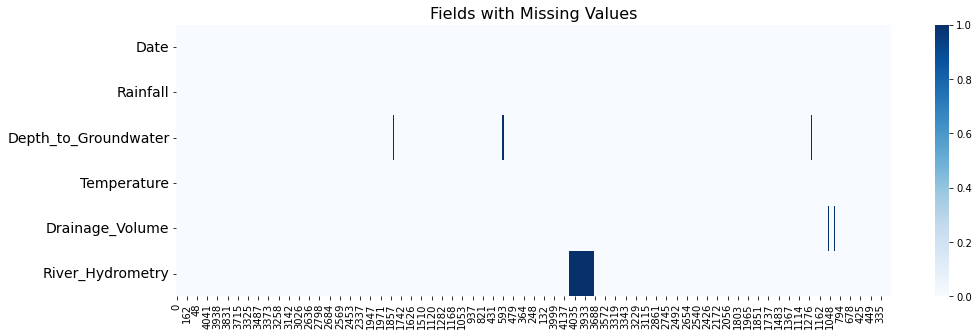

In [8]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
sns.heatmap(df.T.isna(), cmap='Blues')
ax.set_title('Fields with Missing Values', fontsize=16)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

这里采用`interpolate()`方法对缺失值进行填充

In [9]:
df['Drainage_Volume'] = df['Drainage_Volume'].interpolate()
df['River_Hydrometry'] = df['River_Hydrometry'].interpolate()
df['Depth_to_Groundwater'] = df['Depth_to_Groundwater'].interpolate()

#### 重采样

对降雨量Rainfall、温度Temperature等数据进行下采样，以增加一些额外的信息。所谓的下采样，指的是采样频率的下降。例如原本是按天进行统计，下采样之后按月进行统计。

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

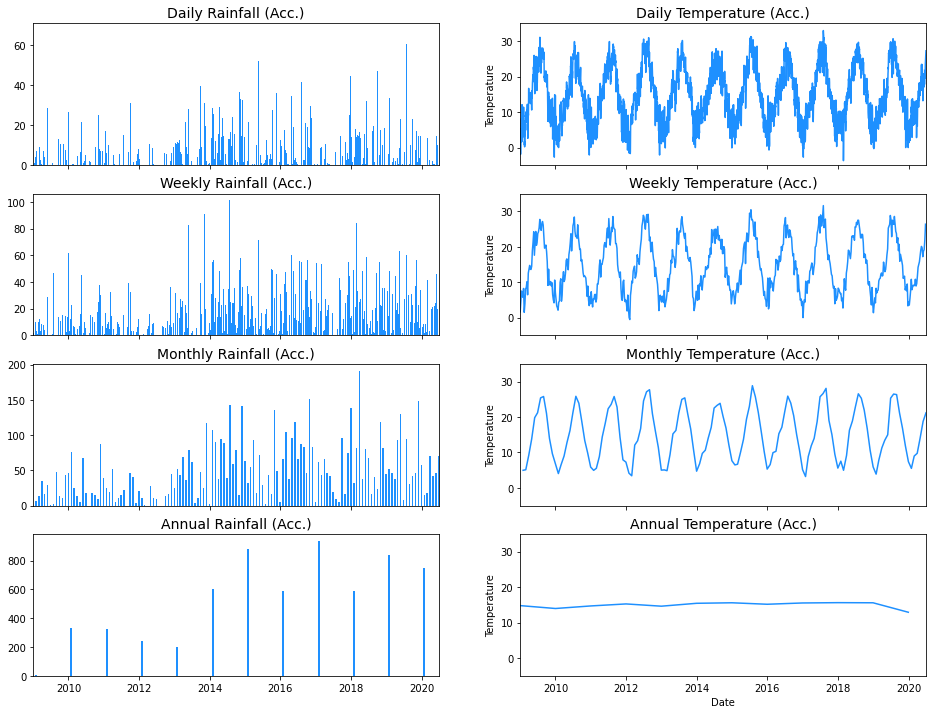

In [10]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,12))

ax[0, 0].bar(df.Date, df.Rainfall, width=5, color='dodgerblue')
ax[0, 0].set_title('Daily Rainfall (Acc.)', fontsize=14)

resampled_df = df[['Date','Rainfall']].resample('7D', on='Date').sum().reset_index(drop=False)
ax[1, 0].bar(resampled_df.Date, resampled_df.Rainfall, width=10, color='dodgerblue')
ax[1, 0].set_title('Weekly Rainfall (Acc.)', fontsize=14)

resampled_df = df[['Date','Rainfall']].resample('M', on='Date').sum().reset_index(drop=False)
ax[2, 0].bar(resampled_df.Date, resampled_df.Rainfall, width=15, color='dodgerblue')
ax[2, 0].set_title('Monthly Rainfall (Acc.)', fontsize=14)

resampled_df = df[['Date','Rainfall']].resample('12M', on='Date').sum().reset_index(drop=False)
ax[3, 0].bar(resampled_df.Date, resampled_df.Rainfall, width=20, color='dodgerblue')
ax[3, 0].set_title('Annual Rainfall (Acc.)', fontsize=14)

for i in range(4):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

sns.lineplot(df.Date, df.Temperature, color='dodgerblue', ax=ax[0, 1])
ax[0, 1].set_title('Daily Temperature (Acc.)', fontsize=14)

resampled_df = df[['Date','Temperature']].resample('7D', on='Date').mean().reset_index(drop=False)
sns.lineplot(resampled_df.Date, resampled_df.Temperature, color='dodgerblue', ax=ax[1, 1])
ax[1, 1].set_title('Weekly Temperature (Acc.)', fontsize=14)

resampled_df = df[['Date','Temperature']].resample('M', on='Date').mean().reset_index(drop=False)
sns.lineplot(resampled_df.Date, resampled_df.Temperature, color='dodgerblue', ax=ax[2, 1])
ax[2, 1].set_title('Monthly Temperature (Acc.)', fontsize=14)

resampled_df = df[['Date','Temperature']].resample('365D', on='Date').mean().reset_index(drop=False)
sns.lineplot(resampled_df.Date, resampled_df.Temperature, color='dodgerblue', ax=ax[3, 1])
ax[3, 1].set_title('Annual Temperature (Acc.)', fontsize=14)

for i in range(4):
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    ax[i, 1].set_ylim([-5, 35])
plt.show()

通过对上图的观察，我们发现，如果按照天的维度，每天的变化较为剧烈；如果按照年的维度，变化又过于缓慢了，规律性不强。综合考虑，最终选择以星期为维度进行下采样。

In [11]:
# 对地下水深度、温度等属性进行下采样，需要对7天的数据进行平均
df_downsampled = df[['Date', 'Depth_to_Groundwater', 'Temperature', 'Drainage_Volume', 'River_Hydrometry']].resample('7D', on='Date').mean().reset_index(drop=False)
# 对降雨量属性进行下采样，需要对7天的数据进行求和
df_downsampled['Rainfall'] = df[['Date', 'Rainfall']].resample('7D', on='Date').sum().reset_index(drop=False)[['Rainfall']]

df = df_downsampled

#### 稳定趋势

通过统计不同时间段下数据的均值、方差来判断是否存在稳定趋势。

In [12]:
num_partitions = 3
partition_length = int(len(df) / num_partitions)

partition1_mean = df[:partition_length].mean()
partition1_var = df[:partition_length].var()
partition2_mean = df[partition_length:partition_length*2].mean()
partition2_var = df[partition_length:partition_length*2].var()
partition3_mean = df[partition_length*2:].mean()
partition3_var = df[partition_length*2:].var()

stationarity_test = pd.concat([partition1_mean, partition2_mean, partition3_mean, partition1_var, partition2_var, partition3_var], axis=1)
stationarity_test.columns = ['Partition 1 Mean', 'Partition 2 Mean', 'Partition 3 Mean', 'Partition 1 Variance', 'Partition 2 Variance', 'Partition 3 Variance']
stationarity_test

<ipython-input-12-0e41cce4be80>:4: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  partition1_mean = df[:partition_length].mean()
<ipython-input-12-0e41cce4be80>:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  partition1_var = df[:partition_length].var()
<ipython-input-12-0e41cce4be80>:6: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  partition2_mean = df[partition_length:partition_length*2].mean()
<ipython-input-12-0e41cce4be80>:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before call

,Partition 1 Mean,Partition 2 Mean,Partition 3 Mean,Partition 1 Variance,Partition 2 Variance,Partition 3 Variance
Depth_to_Groundwater,-27.316011,-22.912114,-25.305836,6.138026e+00,8.850349e+00,1.506472e+00
Temperature,14.964214,15.119929,15.014845,6.158571e+01,5.318235e+01,5.651260e+01
Drainage_Volume,-31525.057749,-27961.617189,-27022.086514,1.411618e+07,8.888450e+06,6.684326e+06
River_Hydrometry,2.176500,2.640929,2.573381,8.044077e-02,9.415265e-02,7.685643e-02
Rainfall,4.933500,13.929000,13.819000,8.737430e+01,3.414279e+02,3.014889e+02


从上表中可以发现，温度、河流水文测量等属性的均值和方差随时间变化较小，可以认为它们具有较为稳定的趋势。
但是，根据常识，我们知道，温度一定是随季节变化的，不应该是稳定的。

这表明，之前的方法对稳定趋势的判断并不准确。

这里引入扩张的迪基-福勒检验（ADF test）的方法。
- 原假设：时间序列有单位根，即时间序列没有稳定状态；
- 替代假设：时间序列没有单位根，即时间序列有稳定状态。

一方面，当$p$值低于一定值，拒绝原假设，通常的阈值是0.05。
- 当$p>=0.05$时，接受原假设，表明时间序列没有稳定状态；
- 当$p<0.05$时，拒绝原假设，表明时间序列有稳定状态。

另一方面，如果ADF的统计量低于临界值，也可以拒绝原假设。
- 当ADF>=临界值时，接受原假设，表明时间序列没有稳定状态；
- 当ADF<临界值时，拒绝原假设，表明时间序列有稳定状态。



In [13]:
# 导入临界值计算工具
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.Depth_to_Groundwater.values)
# ADF统计量
adf_stat = result[0]
# p值
p_val = result[1]
# 临界值
crit_val_1 = result[4]['1%']
crit_val_5 = result[4]['5%']
crit_val_10 = result[4]['10%']

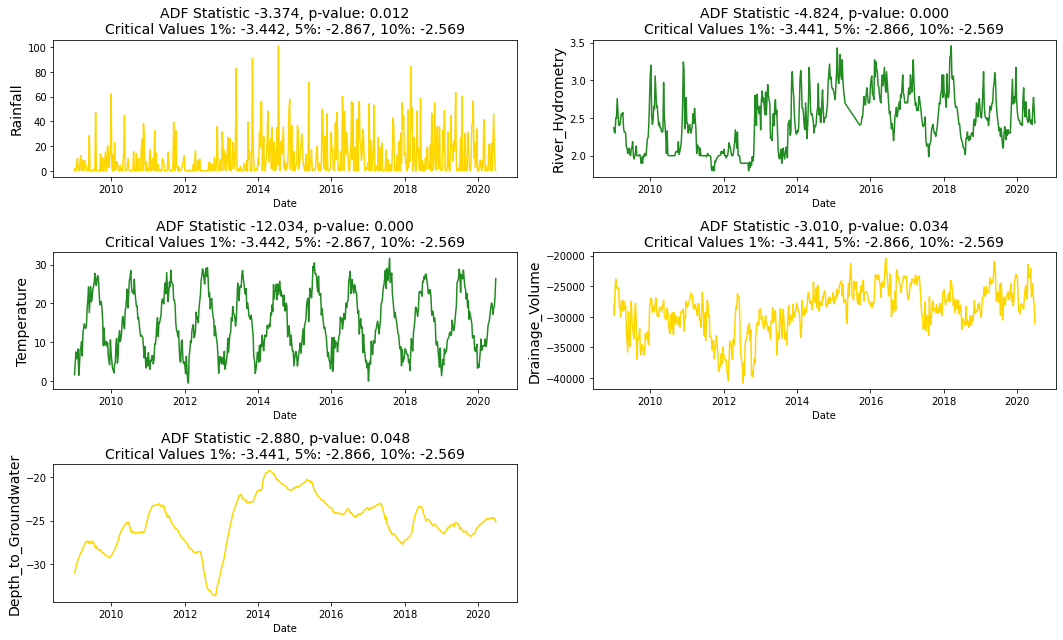

In [14]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'gold'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'orange'
    else:
      linecolor = 'indianred'
    sns.lineplot(x=df.Date, y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(df.Rainfall.values, 'Rainfall', ax[0, 0])
visualize_adfuller_results(df.Temperature.values, 'Temperature', ax[1, 0])
visualize_adfuller_results(df.River_Hydrometry.values, 'River_Hydrometry', ax[0, 1])
visualize_adfuller_results(df.Drainage_Volume.values, 'Drainage_Volume', ax[1, 1])
visualize_adfuller_results(df.Depth_to_Groundwater.values, 'Depth_to_Groundwater', ax[2, 0])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

从上图可以看到，如果以$p$值为标准，那么所有数据都是没有稳定状态的（$p<0.05$）；如果以ADF统计量为标准，那么不同属性的稳定程度是有所差别的。

In [15]:
# 保存文件
df.to_csv(path_or_buf="Aquifer_Petrignano_Weekly.csv", sep=',', header=True, index=False)